In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# Download historical data for AAPL
ticker = 'AAPL'
train = yf.download(ticker, start='2015-01-01', end='2021-12-31', interval='1wk', auto_adjust=False)
train['Returns'] = train['Adj Close'].pct_change()
train.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [3]:
from sklearn.model_selection import ParameterGrid

# Define parameter grid
param_grid = {
    'window': [10,20,30,40,50], 
    'upper_percentage': np.arange(0.01, 1.01, 0.01), 
    'lower_percentage': np.arange(0.01, 0.3, 0.01), 
}

# Evaluate performance for each combination
results = []
for params in ParameterGrid(param_grid):
    data = train.copy()
    # Calculate bands
    data['Middle Band'] = data['Adj Close'].rolling(window=params['window']).mean()
    data['Upper Band'] = data['Middle Band'] * (1 + params['upper_percentage'])
    data['Lower Band'] = data['Middle Band'] * (1 - params['lower_percentage'])

    # Generate signals and calculate returns
    data['Signal'] = 0
    data.loc[data['Adj Close'].squeeze() < data['Lower Band'], 'Signal'] = 1
    data.loc[data['Adj Close'].squeeze() > data['Upper Band'], 'Signal'] = -1
    data['Position'] = data['Signal'].replace(0, np.nan).ffill().fillna(0)
    data['Strategy Returns'] = data['Position'].shift(1) * data['Returns']
    cumulative_returns = (1 + data['Strategy Returns']).cumprod().iloc[-1]

    # Store results
    results.append((params['window'], params['upper_percentage'], 
                    params['lower_percentage'], cumulative_returns))


Best Parameters:
Window                10.000000
Upper Percentage       0.180000
Lower Percentage       0.040000
Cumulative Returns     9.248937
Name: 1585, dtype: float64


/var/folders/82/pcxsy12x1mx1rjvrvznkklxc0000gn/T/ipykernel_57641/3096741457.py:25: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  train['Position'] = train['Signal'].replace(0, method='ffill')


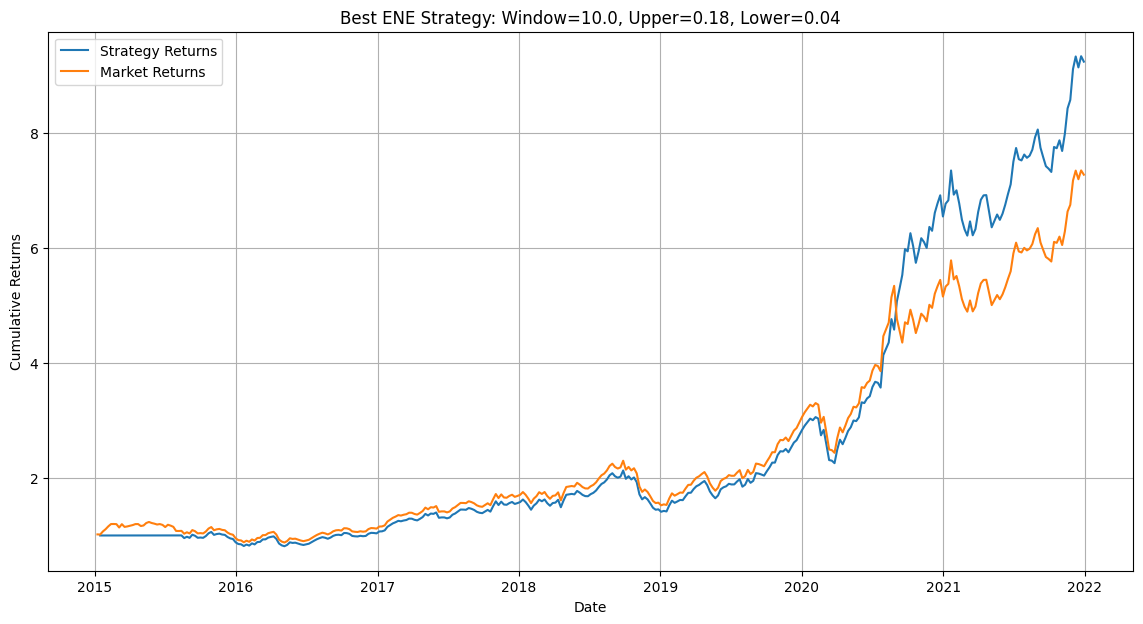

In [4]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Window', 'Upper Percentage', 'Lower Percentage', 'Cumulative Returns'])

# Find the best parameters
best_params = results_df.loc[results_df['Cumulative Returns'].idxmax()]
print("Best Parameters:")
print(best_params)

# Extract the best parameters
best_window = best_params['Window']
best_upper_percentage = best_params['Upper Percentage']
best_lower_percentage = best_params['Lower Percentage']

# Re-run the strategy with the best parameters
train['Middle Band'] = train['Adj Close'].rolling(window=int(best_window)).mean()
train['Upper Band'] = train['Middle Band'] * (1 + best_upper_percentage)
train['Lower Band'] = train['Middle Band'] * (1 - best_lower_percentage)

# Generate signals
train['Signal'] = 0
train.loc[train['Adj Close'].squeeze() < train['Lower Band'], 'Signal'] = 1
train.loc[train['Adj Close'].squeeze() > train['Upper Band'], 'Signal'] = -1

# Forward fill the signals
train['Position'] = train['Signal'].replace(0, method='ffill')

# Calculate strategy returns
train['Strategy Returns'] = train['Position'].shift(1) * train['Returns']

# Calculate cumulative returns
train['Cumulative Strategy Returns'] = (1 + train['Strategy Returns']).cumprod()

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train['Cumulative Strategy Returns'], label='Strategy Returns')
plt.plot((1 + train['Returns']).cumprod(), label='Market Returns')
plt.title(f'Best ENE Strategy: Window={best_window}, Upper={best_upper_percentage:.2f}, Lower={best_lower_percentage:.2f}')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

[*********************100%***********************]  1 of 1 completed
/var/folders/82/pcxsy12x1mx1rjvrvznkklxc0000gn/T/ipykernel_57641/203666039.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  test['Position'] = test['Signal'].replace(0, method='ffill')


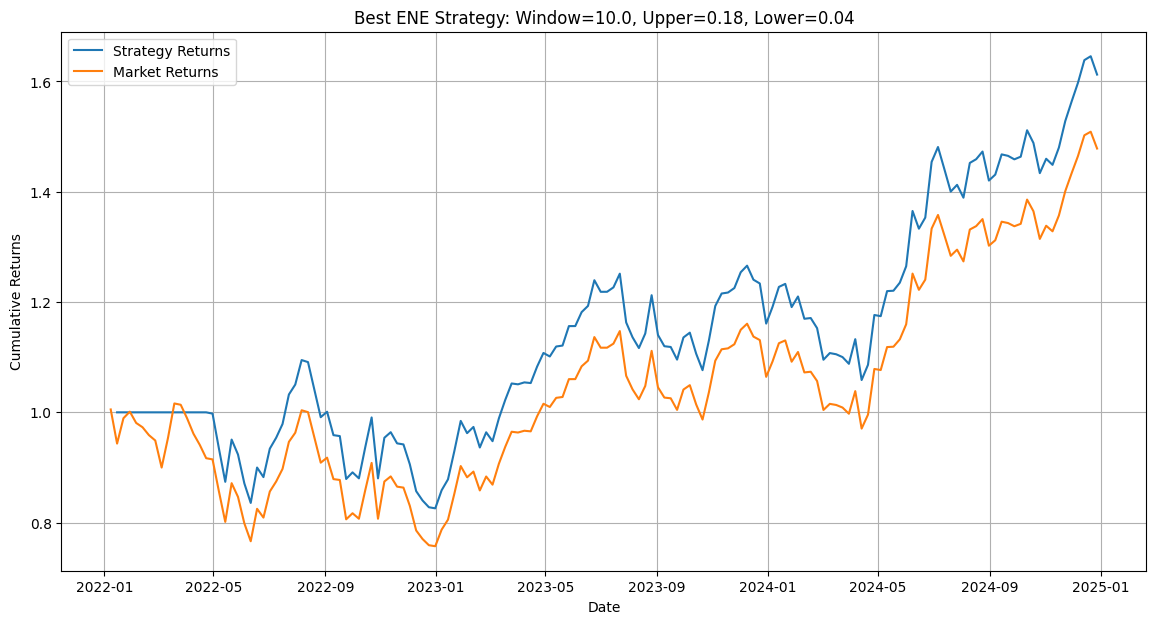

In [6]:
test = yf.download(ticker, start='2022-01-01', end='2024-12-31', interval='1wk', auto_adjust=False)
test['Returns'] = test['Adj Close'].pct_change()
test.dropna(inplace=True)

# Re-run the strategy with the best parameters
test['Middle Band'] = test['Adj Close'].rolling(window=int(best_window)).mean()
test['Upper Band'] = test['Middle Band'] * (1 + best_upper_percentage)
test['Lower Band'] = test['Middle Band'] * (1 - best_lower_percentage)

# Generate signals
test['Signal'] = 0
test.loc[test['Adj Close'].squeeze() < test['Lower Band'], 'Signal'] = 1
test.loc[test['Adj Close'].squeeze() > test['Upper Band'], 'Signal'] = -1

# Forward fill the signals
test['Position'] = test['Signal'].replace(0, method='ffill')

# Calculate strategy returns
test['Strategy Returns'] = test['Position'].shift(1) * test['Returns']

# Calculate cumulative returns
test['Cumulative Strategy Returns'] = (1 + test['Strategy Returns']).cumprod()

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test['Cumulative Strategy Returns'], label='Strategy Returns')
plt.plot((1 + test['Returns']).cumprod(), label='Market Returns')
plt.title(f'Best ENE Strategy: Window={best_window}, Upper={best_upper_percentage:.2f}, Lower={best_lower_percentage:.2f}')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()